# Example: Moving-Horizon Simulataneous Input-and-State Estimation
In this example, we consider a discrete-time linear time-invariant (LTI) system of the form:

$$
\begin{align*}
x_{k+1} &= Ax_k + Bu_k + w_k \\
y_k &= Cx_k + v_k
\end{align*}
$$
with
- $x_k \in \mathbb{R}^n$ represents the system state at time step $k$,
- $u_k \in \mathbb{R}^m$ is the control input at time step $k$,
- $y_k \in \mathbb{R}^p$ is a vector of measured outputs at time step $k$,
- $w_k \in \mathbb{R}^n$ and $v_k \in \mathbb{R}^p$ are process and measurement noise, respectively,
- $A \in \mathbb{R}^{n \times n}$, $B \in \mathbb{R}^{n \times m}$, and $C \in \mathbb{R}^{p \times n}$ are system matrices describing the dynamics and observation model.

The following simultaneous input and state estimation problem is solved:
$$
\begin{aligned}
    &\underset{x, u}{\mathrm{minimize}} \quad \sum_{n=k-N}^{k} u_n^T Q_u^{-1} u_n + \sum_{n=k-N}^{k} v_n^T Q_v^{-1} v_n + \sum_{n=k-N}^{k} w_n^T Q_w^{-1} w_n \\
    &\text{subject to} \\
    &x_{n} = A x_{n-1} + B u_{n-1} + w_n, &\quad n = k-N, \dots, k \\
    &y_n = C x_n + v_n, &\quad n = k-N, \dots, k \\
    &x_0 = \hat{x}_{k-N-1|k-N-1} \\
    &|u| \leq 1,
\end{aligned}
$$
where $Q_v \in \mathbb{R}^{p \times p}$, $Q_w \in \mathbb{R}^{n \times n}$, and $Q_u \in \mathbb{R}^{n \times n}$ are covariance matrices of $v_k$, $w_k$, and $u_k$, respectively.n

### Example LTI system
Consider the slidingn cart system

![cart](https://raw.githubusercontent.com/mmanngard/VirtualSensors/a079e1fe01148c749caa5fd2745499da8c11a760/notebooks/cart.drawio.svg)

where $\mu$ is a friction coefficient, and $F$ is a force applied to the cart.

It is surprising how often this simple school book example can be used to approximate real-world systems! Newton's laws of motion with (net force $F$ equals mass $m$ times acceleration $\ddot{x}$) gives
\begin{equation*}
m\ddot{x} = F - \mu\dot{x},
\end{equation*}
which is a second-order differential equation. This can be rewritten as a set of first-order differential equation by defining new states:
- Position: $x_1=x$
- Velocity: $x_2=\dot{x}$,

and input:

- Net force: $u=F$.

Rewriting the system gives

$$
\begin{bmatrix}
\dot{x}_1\\
\dot{x}_2
\end{bmatrix}
=
\begin{bmatrix}
0 &1\\
0 &-\mu/m
\end{bmatrix}
\begin{bmatrix}
x_1\\
x_2
\end{bmatrix}
+
\begin{bmatrix}
0\\1/m
\end{bmatrix}
u.
$$

Suppose we measure the velocity of the cart, we have
$$
y = \begin{bmatrix}
0 &1
\end{bmatrix}
\begin{bmatrix}
x_1\\
x_2
\end{bmatrix}
+v
$$
where $v$ is measurement noise. This is exacly of the form (1)-(2).

In [1]:
#############################
EXPERIMENT_NAME = 'example_cart' # cvxgen files are stored to: codegen/EXPERIMENT_NAME
COMPILE = True # True | False
#############################


## Create System Model

In [2]:
import numpy as np
from scipy.signal import cont2discrete, StateSpace

mu = 2 #friction coefficient
m = 10 #mass

# Cintinuous-time state space model
A = np.array([[0, 1],[0, -mu/m]])
B = np.array([[0],[1/m]])
C = np.array([[0, 1]])
D = np.zeros([0, 0])

# convert to discrete time model
ts = 0.1
dsys = cont2discrete((A, B, C, D), 1, method='zoh')
Ad, Bd, Cd, Dd, dt_discrete = dsys

# define covariance matrices
Q_u = np.array([1])
Q_v = np.array([1E-3])
Q_w = np.array([[1E-5, 0],[0, 1E-5]])

n_states, n_inputs = np.shape(Bd)
n_outputs = np.shape(Cd)[0]


### Simulate system

In [3]:
from scipy.signal import dlsim, lsim

N = 100 # batch length

# inputs
usim = np.zeros((N,n_inputs))
usim[int(N/2):] = 1

t = np.linspace(0,100,N) #time points
sys = StateSpace(A,B,C)
tsim, ysim, xsim = lsim(sys, U=usim, T=t)

### Plot data

Text(0.5, 0, 'time (s)')

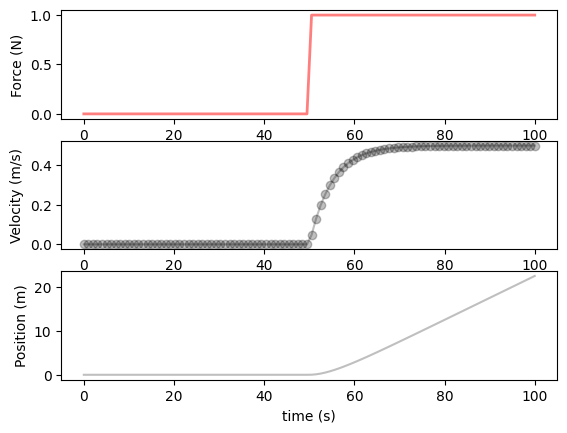

In [4]:
import matplotlib.pyplot as plt

# plot result
fig, axs = plt.subplots(3)
axs[0].plot(tsim, usim,'r', alpha=0.5, linewidth=2, label='input')
axs[0].set_ylabel('Force (N)')
axs[1].plot(tsim,xsim[:,1], color='k', alpha=0.25)
axs[1].scatter(tsim, ysim, alpha=0.25, color='k', edgecolor=None)
axs[1].set_ylabel('Velocity (m/s)')
axs[2].plot(tsim,xsim[:,0], color='k', alpha=0.25)
axs[2].set_ylabel('Position (m)')
plt.xlabel('time (s)')

## Define DPP problem

The problem is reformulated to ensure that it is compliant with [Disciplined Parametrized Programming](https://www.cvxpy.org/tutorial/dpp/index.html) (DPP), which is a standard for specifying parameterised convex optimization problems in tools like CVXPY. A DPP-complient reformulation of the problem is 

$$
\begin{aligned}
    &\underset{X, U, V, W}{\mathrm{minimize}} \quad \| Q_u^{-1/2} U \|_2^2 + \| Q_v^{-1/2} V \|_2^2 + \| Q_w^{-1/2} W \|_2^2 \\
    &\text{subject to} \\
    &X_{:,1:N} = AX_{:,:N-1} + BU \\
    &Y = CX + V \\
    &W_{:,1:} = X_{:,1:N} - AX_{:,:N-1} - BU, \\
    &W_{:,0} = X_{:,0} - \hat{x}_0 \\
    &|U| \leq 1,
\end{aligned}
$$
The subscript notation (e.g., $X_{:,1:N}$ and $X_{:,:N-1}$) works the same way as Python slicing conventions to refer to specific portions of matrices.

In [5]:
from mh_sise.problem import Problem

p = n_outputs
m = n_inputs
n = n_states

problem = Problem(n, m, p, N)

### Add constraints

In [6]:
import cvxpy as cp
# create a new constraints
new_constraint = cp.abs(problem.U) <= 1

# add constraint to problem
problem.add_constraints(new_constraint)


## Solve with `CVXPY`

In [7]:
from scipy.linalg import sqrtm, inv

# assign parameter values
problem.assign_parameter_values(
    Q_v_inv_sqrt = Q_v**(-1/2),
    Q_w_inv_sqrt = sqrtm(inv(Q_w)),
    Q_u_inv_sqrt = Q_u**(-1/2),
    A = Ad,
    B = Bd,
    C = Cd,
    x0 = np.zeros(n),
    y = ysim.reshape((1,N))
)

# solve problem
problem.solve()



CVXPY
Solve time: 16.001 ms
Objective function value: 48.994560



## Generate high-speed solver
Generate code with CVXPYGEN

In [8]:
from cvxpygen import cpg

pth = '../codegen/'
if COMPILE:
    problem.generate_code(pth, EXPERIMENT_NAME)


Generating code with CVXPYgen ...
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1097, constraints m = 996
          nnz(P) + nnz(A) = 3186
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

Getting workspace from OSQP object... 				[done]
Creating target directories... 					[done]
Copying OSQP sources... 					[done]
Generating customized code... 					[done]
Creating project...
[do

## Solve with `CVXPYGEN`

In [10]:
from mh_sise.problem import CProblem
from codegen.example_cart.cpg_solver import cpg_solve

# instantiate problem class saved in path
cproblem = CProblem(pth='../codegen/example_cart/')

# assign parameter values
cproblem.assign_parameter_values(
    Q_v_inv_sqrt = Q_v**(-1/2),
    Q_w_inv_sqrt = sqrtm(inv(Q_w)),
    Q_u_inv_sqrt = Q_u**(-1/2),
    A = Ad,
    B = Bd,
    C = Cd,
    x0 = np.zeros(n),
    y = ysim.reshape((1,N))
)

#solve problem
cproblem.solve(cpg_solve)


Problem loaded from path: ../codegen/example_cart/problem.pickle

CVXPYgen
Solve time: 2.000 ms
Objective function value: 48.994662



## Plot results

(-0.1, 1.1)

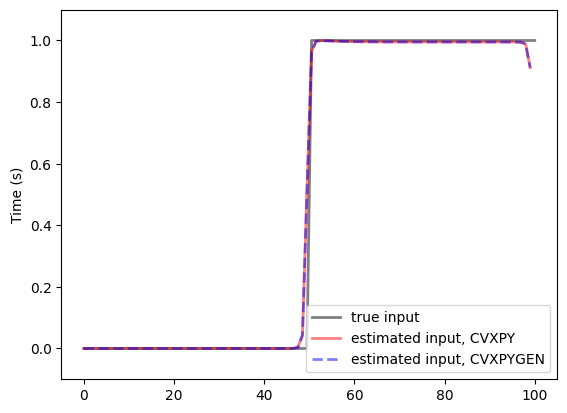

In [11]:
import matplotlib.pyplot as plt

solution = problem.get_variable_values()
csolution = cproblem.get_variable_values()

# plot result
fig, axs = plt.subplots(1)
axs.plot(tsim, usim,'k', alpha=0.5, linewidth=2, label='true input')
axs.plot(tsim[:N-1], solution['U'].T,'r', alpha=0.5, linewidth=2, label='estimated input, CVXPY')
axs.plot(tsim[:N-1], csolution['U'].T,'b--', alpha=0.5, linewidth=2, label='estimated input, CVXPYGEN')
axs.set_ylabel('Force (N)')
axs.set_ylabel('Time (s)')
axs.set_ylim([-1, 1])
axs.legend()
axs.set_ylim((-0.1, 1.1))